# Analyzing high volume German court decisions in an interdisciplinary class of law and computer science students – LSIA

The paper can be found at ...

## ML evaluation (Section 4.2)

In [0]:
# Load data and seperate test data set
ml_data = pd.read_csv("Results/ml_data.csv", names=["id", 
                                            'az', 
                                            'true',
                                            'predicted', 
                                            'testset'])
ml_testset = ml_data[ml_data.testset==1]
ml_trainingset = ml_data[ml_data.testset!=1]

ml_labels = [
    1, # Success label
    -1, # Failure label
    -99 # Miscellaneous label
]

### Number of annotated decisions, size of training/test set

In [0]:
print('Number of annotated decision: {}'.format(len(ml_data)))
print('Size of training set: {}'.format(len(ml_trainingset)))
print('Size of test set: {}'.format(len(ml_testset)))

Number of annotated decision: 1991
Size of trainig set: 1769
Size of test set: 222


### Table 1: Evaluation of Appeal Outcome Classification

In [0]:
from sklearn.metrics import precision_recall_fscore_support
from scipy import stats
import numpy as np

def ml_scores(datatset):
  scores = precision_recall_fscore_support(datatset['true'], 
                                           datatset['predicted'], 
                                           labels=ml_labels, 
                                           average=None)
  return pd.DataFrame(data=list(scores), 
               index=['precision', 'recall', 'fbeta_score', 'support'], 
               columns=ml_labels).T

In [0]:
# Test set scores
ml_scores(ml_testset)

,precision,recall,fbeta_score,support
1,0.866667,0.951220,0.906977,82.0
-1,0.915966,0.923729,0.919831,118.0
-99,0.615385,0.363636,0.457143,22.0


In [0]:
# Training set scores
ml_scores(ml_trainingset)

,precision,recall,fbeta_score,support
1,0.934037,0.977901,0.955466,724.0
-1,0.954853,0.957014,0.955932,884.0
-99,0.888000,0.689441,0.776224,161.0


### Table 2: Confusion Matrix of Appeal Outcome Classification

In [0]:
from sklearn.metrics import confusion_matrix

def ml_confusion_matrix(datatset):
  scores = confusion_matrix(datatset['true'], 
                            datatset['predicted'], 
                            labels=ml_labels)
  return pd.DataFrame(data=list(scores), index=ml_labels, columns=ml_labels)

In [0]:
# Test set confusion matrix
ml_confusion_matrix(ml_testset)

,1,-1,-99
1,78,4,0
-1,4,109,5
-99,8,6,8


In [0]:
# Trainig set confusion matrix
ml_confusion_matrix(ml_trainingset)

,1,-1,-99
1,708,12,4
-1,28,846,10
-99,22,28,111


## Statistical Description of the Corpus (Section 4.3)

In [0]:
# Load data
bgh_data = pd.read_csv('Results/bgh_data.csv')
bgh_data = bgh_data.fillna('')

In [0]:
# Add senat to data
bgh_data['Senat'] = [obj.split(' ')[0] for obj in bgh_data.DocketNumber]

bgh_data['MainSenat'] =  bgh_data.Senat.map(lambda senat: senat in 
                                  ['1','2','3','4','5','I','II',
                                   'III','IV','V','VI','VII','VIII',
                                   'IX','X','XI','XII'])


# Add previous instance (including date)
def find_previous_instance(row):
    if (len(row.DecisionOLG) > 0):
        return row.DecisionOLG
    if (len(row.DecisionLG) > 0):
        return row.DecisionLG
    if (len(row.DecisionAG) > 0):
        return row.DecisionAG
    return ""
bgh_data['DecisionPrevious'] = bgh_data.apply(find_previous_instance, axis=1)

def find_previous_instance_date(row):
    if (len(row.DecisionOLG) > 0):
        return row.DateOLG
    if (len(row.DecisionLG) > 0):
        return row.DateLG
    if (len(row.DecisionAG) > 0):
        return row.DateAG
    return 0
bgh_data['DatePrevious'] = bgh_data.apply(find_previous_instance_date, axis=1)

In [0]:
from datetime import datetime, timezone, timedelta

# Add weekday
def epoche_to_day(ep):
  if ep == 0:
    return None
  return datetime.fromtimestamp(ep/1000, timezone(timedelta(hours=2))).strftime("%A")

bgh_data['Weekday'] = bgh_data.DateDecision.map(epoche_to_day)

# Add duration
def add_duration(row):
  if row.DatePrevious > 0:
    return round((row.DateDecision-row.DatePrevious)/1000/3600/24) 
  return None

bgh_data['Duration'] = bgh_data.apply(add_duration, axis=1)

# Mark criminal decisions (Docker numbers begin with one arabic number)
bgh_data['Criminal'] = bgh_data.DocketNumber.str.contains('^\d\s', regex=True)

In [0]:
bgh_docket_number = bgh_data[bgh_data['Senat']!=""]
bgh_main_senats = bgh_docket_number[bgh_docket_number.MainSenat]

bgh_criminal = bgh_docket_number[bgh_docket_number.Criminal == True]
bgh_civil = bgh_docket_number[bgh_docket_number.Criminal != True]

In [0]:
olg_distances = pd.read_csv('./Results/olg_distances.csv')

### The Population (Section 4.3.1)

In [0]:
print("Total number of decisions: {}".format(len(bgh_data)))


print("Number of decisions with docket number: {}".format(
    len(bgh_docket_number)))

print("Number of decisions with docket number and decision outcome: {}".format(
    len(bgh_docket_number[bgh_docket_number.RevisionOutcome!=-99])))


Total number of decisions: 56288
Number of decisions with docket number: 56011
Number of decisions with docket number and decision outcome: 53573


In [0]:
def calculate_ratios(df):
  counts = df.RevisionOutcome.value_counts()
  print("Successful decisions: {} or {}".format(
      counts[1],
      counts[1] / (counts[1]+counts[-1])
  ))
  print("Unsuccessful decisions: {} or {}".format(
      counts[-1],
      counts[-1] / (counts[1]+counts[-1])
  ))
  print("Miscellaneous decisions: {}".format(
      counts[-99])
  )
  print("Total decisions: {}".format(
      len(df))
  ) 

In [0]:
# All decisions with docket number
calculate_ratios(bgh_docket_number)

Successful decisions: 24658 or 0.4602691654378138
Unsuccessful decisions: 28915 or 0.5397308345621862
Miscellaneous decisions: 2438
Total decisions: 56011


In [0]:
# Criminal decisions
calculate_ratios(bgh_criminal)

Successful decisions: 10294 or 0.5554716166630693
Unsuccessful decisions: 8238 or 0.44452838333693073
Miscellaneous decisions: 733
Total decisions: 19265


In [0]:
# Civil decisions
calculate_ratios(bgh_civil)

Successful decisions: 14364 or 0.4099198082246511
Unsuccessful decisions: 20677 or 0.5900801917753489
Miscellaneous decisions: 1705
Total decisions: 36746


In [0]:
counts_civil = bgh_civil.RevisionOutcome.value_counts()
counts_criminal = bgh_criminal.RevisionOutcome.value_counts()
print("Delta success quote: {}".format(
    counts_criminal[1] / (counts_criminal[1]+counts_criminal[-1]) -
    counts_civil[1] / (counts_civil[1]+counts_civil[-1])
)) 

Delta success quote: 0.1455518084384182


### Temporal Analysis (Section 4.3.2)

In [0]:
def filter_weekday(df):
  '''
  Removes decisions on weekends and with undefined days
  '''
  filter = [day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
           for day in df.Weekday]
  return df[filter]

def analyse_weekday(df):
  result = []
  for name,group in df[df.RevisionOutcome > -2].groupby('Weekday'):
    result.append([
        name,
        group['RevisionOutcome'].mean()/2+0.5, # Convert -1, 1 to 0, 1
        len(group),
    ])
  result = pd.DataFrame(result, columns=['Weekday','SuccessRates','Count'])
  result['Distribution'] = result.Count/result.Count.sum()
  result = result.set_index('Weekday')
  return result

In [0]:
analyse_weekday(filter_weekday(bgh_civil)).sort_values('Distribution', 
                                                       ascending=False)

,SuccessRates,Count,Distribution
Weekday,,,
Thursday,0.388906,13340,0.381186
Wednesday,0.443649,8385,0.239599
Tuesday,0.433333,8070,0.230598
Monday,0.292027,3349,0.095697
Friday,0.522678,1852,0.052920


In [0]:
analyse_weekday(filter_weekday(bgh_criminal)).sort_values('Distribution', 
                                                          ascending=False)

,SuccessRates,Count,Distribution
Weekday,,,
Tuesday,0.554276,6513,0.351579
Wednesday,0.545237,6267,0.338300
Thursday,0.581319,4593,0.247935
Friday,0.539894,752,0.040594
Monday,0.462500,400,0.021592


In [0]:
weekday_counts = analyse_weekday(filter_weekday(bgh_docket_number))['Distribution']
print("{} of the decisions are handed down between Tue and Thu.".format(
    weekday_counts.Tuesday + 
    weekday_counts.Wednesday + 
    weekday_counts.Thursday
))

0.8812989293922012 of the decisions are handed down between Tue and Thu.


In [0]:
bgh_main_senats_weekdays = filter_weekday(
    bgh_docket_number[bgh_docket_number.MainSenat])
crosstable_weekdays_senats = pd.crosstab(bgh_main_senats_weekdays.Weekday,
                                         bgh_main_senats_weekdays.Senat)
crosstable_weekdays_senats

Senat,1,2,3,4,5,I,II,III,IV,IX,V,VI,VII,VIII,X,XI,XII
Weekday,,,,,,,,,,,,,,,,,
Friday,71,581,96,13,35,11,21,13,15,91,1231,17,5,1,0,7,1
Monday,82,68,37,35,200,39,1282,7,88,209,59,109,24,33,68,57,22
Thursday,595,651,1408,1323,714,2444,51,2271,58,4929,1752,49,1425,10,106,23,66
Tuesday,1281,557,1794,1636,1349,71,713,45,126,447,91,2060,70,715,1449,1766,18
Wednesday,1104,2854,575,633,1329,437,76,245,2060,265,260,58,195,1663,133,41,2840


In [0]:
crosstable_weekdays_senats_rel = pd.DataFrame()
for column in crosstable_weekdays_senats.columns:
  crosstable_weekdays_senats_rel[column] = crosstable_weekdays_senats[column]/\
      crosstable_weekdays_senats[column].sum()

In [0]:
crosstable_weekdays_senats_rel.T.describe()

Weekday,Friday,Monday,Thursday,Tuesday,Wednesday
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.035385,0.057072,0.310967,0.313816,0.282760
std,0.089184,0.140277,0.335120,0.318681,0.311015
min,0.000000,0.002712,0.004129,0.006108,0.021647
25%,0.003571,0.012991,0.023798,0.040721,0.075740
50%,0.006391,0.017389,0.189914,0.295211,0.145570
75%,0.015317,0.037495,0.516357,0.449451,0.366419
max,0.362806,0.598227,0.879892,0.932418,0.963692


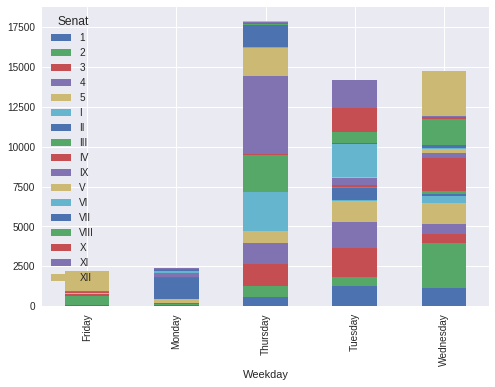

In [0]:
plt.figure();
crosstable_weekdays_senats.plot.bar(stacked=True)

In [0]:
# Repetition but new sorting
analyse_weekday(filter_weekday(bgh_civil)).sort_values('SuccessRates')

,SuccessRates,Count,Distribution
Weekday,,,
Monday,0.292027,3349,0.095697
Thursday,0.388906,13340,0.381186
Tuesday,0.433333,8070,0.230598
Wednesday,0.443649,8385,0.239599
Friday,0.522678,1852,0.052920


In [0]:
# Repetition but new sorting
analyse_weekday(filter_weekday(bgh_criminal)).sort_values('SuccessRates')

,SuccessRates,Count,Distribution
Weekday,,,
Monday,0.462500,400,0.021592
Friday,0.539894,752,0.040594
Wednesday,0.545237,6267,0.338300
Tuesday,0.554276,6513,0.351579
Thursday,0.581319,4593,0.247935


In [0]:
# Ratio: decisions on weekends
(len(bgh_docket_number[bgh_docket_number.Weekday=='Saturday'])+len(bgh_docket_number[bgh_docket_number.Weekday=='Sunday']))/len(filter_weekday(bgh_docket_number))

0.0005050413953572266

In [0]:
senats_success_rates = pd.crosstab(bgh_main_senats.Senat, 
                                   bgh_main_senats.RevisionOutcome)
senats_success_rates['SuccessRate'] = senats_success_rates[1] / \
      (senats_success_rates[1]+senats_success_rates[-1])
senats_success_rates['Total'] = senats_success_rates[-99] + \
                                senats_success_rates[-1] + \
                                senats_success_rates[1]
senats_success_rates['Criminal'] = senats_success_rates.index.str.contains('^\d$', regex=True)
senats_success_rates.sort_values('SuccessRate')

RevisionOutcome,-99,-1,1,SuccessRate,Total,Criminal
Senat,,,,,,
IX,217,4197,1555,0.270341,5969,False
IV,67,1507,788,0.343355,2362,False
III,83,1618,897,0.356660,2598,False
1,80,1773,1317,0.426214,3170,True
XI,49,1060,791,0.427337,1900,False
X,142,904,741,0.450456,1787,False
VI,76,1165,1064,0.477344,2305,False
I,133,1508,1388,0.479282,3029,False
5,133,1859,1713,0.479563,3705,True


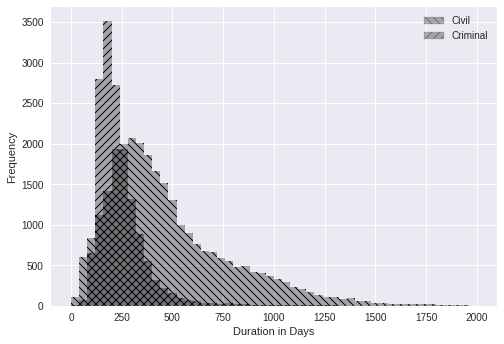

In [0]:
plt.figure();
from matplotlib.patches import Patch
custom_lines = [Patch(alpha=0.3, color='k', hatch = '\\\\\\'),
                Patch(alpha=0.3, color='k', hatch = '///')]
fig, ax = plt.subplots()
l = ax.legend(custom_lines, ['Civil', 'Criminal'])
l.set_title("")
bgh_civil.Duration.plot.hist(bins=50, range=(0,2000), alpha=0.3, color='k', hatch = '\\\\\\')
bgh_criminal.Duration.plot.hist(bins=50, range=(0,2000), alpha=0.3, color='k', hatch = '///')

plt.xlabel('Duration in Days')

plt.savefig('Results/HistogramDurationFrequency.png', bbox_inches='tight', format='png', dpi=600)


In [0]:
bgh_civil.Duration.describe()

count    27972.000000
mean       489.188295
std        359.078379
min          1.000000
25%        259.000000
50%        400.000000
75%        636.000000
max      11367.000000
Name: Duration, dtype: float64

In [0]:
bgh_criminal.Duration.describe()

count    15680.000000
mean       247.138520
std        193.786527
min         14.000000
25%        163.000000
50%        211.000000
75%        281.000000
max       9687.000000
Name: Duration, dtype: float64

### Previous Instance (Section 4.3.3)

In [0]:
olg_civil_success_rates = pd.crosstab(bgh_civil.DecisionOLG, 
                                      bgh_civil.RevisionOutcome)
olg_civil_success_rates['SuccessRate'] = olg_civil_success_rates[1] / \
      (olg_civil_success_rates[1]+olg_civil_success_rates[-1])
olg_civil_success_rates = olg_civil_success_rates[olg_civil_success_rates.index != ""]
olg_civil_success_rates.sort_values('SuccessRate')

RevisionOutcome,-99,-1,1,SuccessRate
DecisionOLG,,,,
OLG Karlsruhe,43,960,567,0.371316
OLG Nürnberg,15,331,198,0.374291
OLG Hamm,44,885,542,0.379818
OLG Stuttgart,34,666,416,0.384473
OLG Saarbrücken,3,90,57,0.387755
OLG Bamberg,5,205,133,0.393491
OLG Köln,37,919,619,0.402471
OLG Celle,33,681,485,0.415952
OLG Hamburg,19,623,446,0.417212


In [0]:
olg_civil_success_rates.SuccessRate.describe()

count    24.000000
mean      0.435006
std       0.040074
min       0.371316
25%       0.400226
50%       0.439753
75%       0.472861
max       0.506452
Name: SuccessRate, dtype: float64

In [0]:
olg_criminal_success_rates = pd.crosstab(bgh_criminal.DecisionOLG, 
                                      bgh_criminal.RevisionOutcome)
olg_criminal_success_rates['SuccessRate'] = \
      olg_criminal_success_rates[1] / \
      (olg_criminal_success_rates[1]+olg_criminal_success_rates[-1])

olg_criminal_success_rates_filtered = olg_criminal_success_rates[olg_criminal_success_rates.index != ""]

count_criminal_olg = olg_criminal_success_rates_filtered[-1].sum() + olg_criminal_success_rates_filtered[1].sum()
count_criminal_total = olg_criminal_success_rates[-1].sum() + olg_criminal_success_rates[1].sum()
print("{} ({}) cases have an OLG as previous instance".format(count_criminal_olg, count_criminal_olg/count_criminal_total))

385 (0.020774875890351825) cases have an OLG as previous instance


In [0]:
previous_criminal_success_rates = pd.crosstab(bgh_criminal.DecisionPrevious, 
                                      bgh_criminal.RevisionOutcome)
previous_criminal_success_rates['SuccessRate'] = \
      previous_criminal_success_rates[1] / \
      (previous_criminal_success_rates[1]+previous_criminal_success_rates[-1])

previous_criminal_success_rates[previous_criminal_success_rates.index != ""] \
      .SuccessRate.describe()

count    274.000000
mean       0.564800
std        0.351188
min        0.000000
25%        0.348974
50%        0.597861
75%        1.000000
max        1.000000
Name: SuccessRate, dtype: float64

In [0]:
previous_criminal_success_rates[previous_criminal_success_rates.index != ""].describe()

RevisionOutcome,-99,-1,1,SuccessRate
count,318.000000,318.000000,318.000000,274.000000
mean,0.761006,22.930818,30.638365,0.564800
std,1.250661,50.873830,63.530201,0.351188
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.348974
50%,0.000000,1.000000,1.000000,0.597861
75%,1.000000,24.750000,32.000000,1.000000
max,8.000000,594.000000,509.000000,1.000000


In [0]:
def distance_for_olg(olg_name,distance_column):
  if len(olg_distances[olg_distances.OLG == olg_name][distance_column].values):
    return olg_distances[olg_distances.OLG == olg_name] \
                        [distance_column].values.item(0)
  return None

olg_civil_success_rates['Distance'] = olg_civil_success_rates.index.map(
    lambda olg: distance_for_olg(olg,'BGH Karlsruhe'))
olg_civil_success_rates

RevisionOutcome,-99,-1,1,SuccessRate,Distance
DecisionOLG,,,,,
Kammergericht,16,860,780,0.475610,668
OLG Bamberg,5,205,133,0.393491,279
OLG Brandenburg,25,315,282,0.472362,624
OLG Braunschweig,10,153,157,0.506452,466
OLG Bremen,6,86,66,0.434211,575
OLG Celle,33,681,485,0.415952,509
OLG Dresden,37,507,407,0.445295,548
OLG Düsseldorf,60,1184,878,0.425800,339
OLG Frankfurt,65,1328,968,0.421603,145


In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression  
from scipy import stats

linregress_result = stats.linregress(olg_civil_success_rates.Distance,
                 olg_civil_success_rates.SuccessRate)

print("Slope:            {}".format(linregress_result.slope))
print("Intercept:        {}".format(linregress_result.intercept))
print("r-value:          {}".format(linregress_result.rvalue))
print("r-squared-value:  {}".format(linregress_result.rvalue**2))
print("pvalue:           {}".format(linregress_result.pvalue))
print("stderr:           {}".format(linregress_result.stderr))


Slope:            0.00010710563669288431
Intercept:        0.39246317712867884
r-value:          0.5911386278051841
r-squared-value:  0.349444877283396
pvalue:           0.00235026644718121
stderr:           3.115686110059794e-05


In [0]:
def y_standard_error(x, y, intercept, slope):
  return np.sqrt(((intercept+slope*x-y)**2).sum()/(len(x)-2))

olg_civil_success_rates_y_standard_error = y_standard_error(olg_civil_success_rates.Distance,
                 olg_civil_success_rates.SuccessRate,
                 linregress_result.intercept,
                 linregress_result.slope)
olg_civil_success_rates_y_standard_error

0.03304910283045973

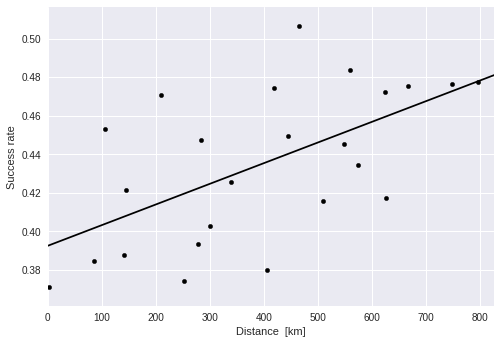

In [261]:
y = olg_civil_success_rates.SuccessRate.values
x = olg_civil_success_rates.Distance.values

plt.figure()

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=0
mx=np.max(x)+30
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept

ax = olg_civil_success_rates.plot.scatter(y='SuccessRate', x='Distance', xlim=(mn,np.max(x)+30), ylim=(np.min(y)-.01,np.max(y)+.01), color='k')
ax.set_ylabel("Success rate")
ax.set_xlabel("Distance  [km]")
plt.plot(x1,y1,'-r', color='k')
plt.savefig('Results/LinearRegressionSuccessDistance.png', bbox_inches='tight', format='png', dpi=600)


### Judges

In [0]:
bgh_docket_number_judges_exploded = []

for _,decision in bgh_main_senats.iterrows():
  for judge in decision.Judges.split(','):
    bgh_docket_number_judges_exploded.append([
        decision.RevisionOutcome,
        decision.Senat,
        decision.Criminal,
        judge,
    ])
bgh_docket_number_judges_exploded = pd.DataFrame( \
    bgh_docket_number_judges_exploded, \
    columns=['RevisionOutcome','Senat','Criminal','Judge'])

In [0]:
judges_success_rates = pd.crosstab([
            bgh_docket_number_judges_exploded.Criminal,
            bgh_docket_number_judges_exploded.Senat,
            bgh_docket_number_judges_exploded.Judge],
            bgh_docket_number_judges_exploded.RevisionOutcome)
judges_success_rates['Recognized'] = judges_success_rates.apply(lambda row: \
      row[1]+row[-1]
      , axis=1)
judges_success_rates['SuccessRate'] = judges_success_rates.apply(lambda row: \
      row[1]/row.Recognized if row.Recognized>0 else None
      , axis=1)
judges_success_rates = judges_success_rates.reset_index(level=['Criminal','Senat','Judge'])
judges_success_rates = judges_success_rates[ \
    judges_success_rates.Judge != ""]

In [0]:
judges_success_rates_civil = judges_success_rates[ \
      judges_success_rates.Criminal != True]
judges_success_rates_civil[ \
      judges_success_rates_civil.Recognized>=100].SuccessRate.describe()

count    198.000000
mean       0.458059
std        0.101997
min        0.170732
25%        0.405278
50%        0.477168
75%        0.519436
max        0.746875
Name: SuccessRate, dtype: float64

In [0]:
judges_success_rates_criminal = judges_success_rates[ \
      judges_success_rates.Criminal]
judges_success_rates_criminal[ \
      judges_success_rates_criminal.Recognized>=100].SuccessRate.describe()

count    92.000000
mean      0.552434
std       0.102745
min       0.328933
25%       0.486185
50%       0.577330
75%       0.639064
max       0.748792
Name: SuccessRate, dtype: float64

In [0]:
judges_success_rates['Óther-1'] = judges_success_rates.apply(
    lambda row: senats_success_rates.loc[row.Senat][-1] - row[-1]
    ,axis=1)
judges_success_rates['Óther1'] = judges_success_rates.apply(
    lambda row: senats_success_rates.loc[row.Senat][1] - row[1]
    ,axis=1)

In [0]:
from scipy.stats import chi2_contingency
import math

def calculate_chisquare_test(row):
  obs = [[row[1], row[-1]],
         [row['Óther1'], row['Óther-1']]]
  for a in [row[1], row[-1], row['Óther1'], row['Óther-1']]:
    if a < 5:
      return None
  chi2_test = chi2_contingency(obs)
  p = chi2_test[1]
  phi = math.sqrt(chi2_test[0]/(row[1] + row[-1] + row['Óther1'] + row['Óther-1']))

  return (p, phi)

chi2_test_results = judges_success_rates.apply(calculate_chisquare_test, axis=1)
judges_success_rates["chi2p"]   = [(round(obj[0], 6)   if obj else None) \
                                   for obj in chi2_test_results] 
judges_success_rates["chi2phi"] = [(round(obj[1], 6) if obj else None) \
                                   for obj in chi2_test_results]
significant_judges_success_rates = judges_success_rates[judges_success_rates.chi2p <= 0.01]
significant_judges_success_rates = significant_judges_success_rates[ \
      significant_judges_success_rates.chi2phi >=0.1]


In [0]:
print("Significant judges: {}".format(len(significant_judges_success_rates)))

Significant judges: 35


In [0]:
# Cramer's V of significant judges
significant_judges_success_rates.chi2phi.describe()

count    35.000000
mean      0.128829
std       0.033543
min       0.100032
25%       0.106302
50%       0.116810
75%       0.139601
max       0.237724
Name: chi2phi, dtype: float64

In [0]:
other_judges_success_rates = significant_judges_success_rates.Óther1 / \
                    (significant_judges_success_rates.Óther1 + \
                    significant_judges_success_rates['Óther-1'])

judges_lower_count = len(significant_judges_success_rates[
                   significant_judges_success_rates.SuccessRate < 
                   other_judges_success_rates
                   ])

judges_higher_count = len(significant_judges_success_rates[
                   significant_judges_success_rates.SuccessRate >= 
                   other_judges_success_rates
                   ])

print("Significantly lower judges {}".format(judges_lower_count))
print("Significantly higher judges {}".format(judges_higher_count))

Significantly lower judges 17
Significantly higher judges 18


In [0]:
linregress_result = stats.linregress(
      senats_success_rates[senats_success_rates.Criminal==True].Total,
      senats_success_rates[senats_success_rates.Criminal==True].SuccessRate)

print("Slope:            {}".format(linregress_result.slope))
print("Intercept:        {}".format(linregress_result.intercept))
print("r-value:          {}".format(linregress_result.rvalue))
print("r-squared-value:  {}".format(linregress_result.rvalue**2))
print("pvalue:           {}".format(linregress_result.pvalue))
print("stderr:           {}".format(linregress_result.stderr))

Slope:            8.626170429016421e-05
Intercept:        0.21706362198553958
r-value:          0.5452020196860008
r-squared-value:  0.2972452422696944
pvalue:           0.34194174269280125
stderr:           7.657761712691041e-05


In [0]:
linregress_result = stats.linregress(
      senats_success_rates[senats_success_rates.Criminal!=True].Total,
      senats_success_rates[senats_success_rates.Criminal!=True].SuccessRate)

print("Slope:            {}".format(linregress_result.slope))
print("Intercept:        {}".format(linregress_result.intercept))
print("r-value:          {}".format(linregress_result.rvalue))
print("r-squared-value:  {}".format(linregress_result.rvalue**2))
print("pvalue:           {}".format(linregress_result.pvalue))
print("stderr:           {}".format(linregress_result.stderr))

Slope:            -4.331577419799812e-05
Intercept:        0.5684954832553419
r-value:          -0.5693398546258986
r-squared-value:  0.3241478700654394
pvalue:           0.053335194144576284
stderr:           1.9778818189863415e-05
